# Caso studio: l'algoritmo All-Pairs N-Body

In questo esercizio guidato applicherai applicheremo il parallelismo ad un esempio tratto dal mondo reale: il problema degli $N$-corpi, o in inglese $N$-body. Questo problema è molto importante nell'ambito della fisica computazionale, infatti la soluzione analitica è nota solo con $N=2$ e in alcuni casi con $N=3$, perciò poter calcolare una soluzione numerica è fondamentale.

Dati $N$ corpi con posizioni iniziali $x_i$, massa $m_i$ e velocità $v_i$, $1 \leq i \leq N$, definiamo la forza $f_{ij}$ esercitata dal corpo $j$ sul corpo $i$ come
$$ f_{ij} = G\frac{m_im_j r_{ij}}{\Vert r_{ij} \Vert^3 }, $$
dove $r_{ij} = x_j - x_i$.
La forza fotale esercitata sul corpo $i$-esimo è dunque
$$ F_i = \sum_{j \neq i} f_{ij} = G m_i \sum_{j \neq i}  \frac{m_j r_{ij}}{\Vert r_{ij} \Vert^3 }. $$
Quando due particelle si avvicinano troppo, la forza $f_{ij}$ che agisce tra di loro va all'infinito. Per impedire problemi numerici, introduciamo un fattore di smorzamento $\varepsilon>0$
$$ F_i \approx G m_i \sum_{j}  \frac{m_j r_{ij}}{(\Vert r_{ij} \Vert^2 + \varepsilon^2)^{3/2} }. $$
La condizione $j \neq i$ non è più necessaria perchè quando $r_{ii} = 0$ il fattore di smorzamento impedisce che il denominatore vada a zero.

Per integrare le leggi del moto
$$ a(t) = \frac{dv}{dt}(t) = \frac{dx^2}{dt^2}(t), \\  v(t) = \frac{dx}{dt}(t), $$
abbiamo bisogno dell'accelerazione, che ricaviamo applicando la seconda legge di Newton $a = F/m$. L'accelerazione della particella $i$-esima è quindi data da
$$ a_i \approx G \sum_{j}  \frac{m_j r_{ij}}{(\Vert r_{ij} \Vert^2 + \varepsilon^2)^{3/2} }. $$

Integrando nel tempo (in questo caso utilizzando prima Eulero Esplicito, poi Eulero Implicito), si ottiene l'evoluzione discreta di posizione e velocità:
$$ v_{k+1} = a_k\cdot dt + v_k, \\  x_{k+1} = v_{k+1} \cdot dt + x_k = a_k\cdot dt^2 + v_k\cdot dt + x_k. $$

### Scelta dei tipi
Nel seguito vedremo l'implementazione nel caso due dimensionale. Scegliamo di vedere il piano $\mathbb{R}^2$ come il piano complesso $\mathbb{C}$, percio' la posizione $x$ di un corpo sara' data da $x = (a,b) = a+ib.$


In [ ]:
import numpy as np
import time
from numba import cuda
from numba import float32, complex64, void
import math
import numba
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [ ]:
EPS2 = 0.02

In [ ]:
def accerelation(x_i, x, m):
    """Accelerazione della particella i-esima"""

    #vettore r_ij
    r = x - x_i

    distSqrt = np.square(r.real) + np.square(r.imag)

    #vettore f_ij
    f = m*np.power(  distSqrt + EPS2 , -1.5)

    a = np.sum(r*f)

    return a


In [ ]:
def simulate_cpu(x0, v0, m, N, maxit, dt):

    x = np.zeros_like(x0)
    v = np.zeros_like(v0)

    for s in range(maxit):
        for i in range(N):
            #calcolo l'accererazione
            a_i  = accerelation(x0[i], x0, m)
            #aggiorno le variabili
            v[i] = a_i * dt + v0[i]
            x[i] = a_i * dt * dt + v0[i] * dt + x0[i]
        #endfor
        x0, v0 = x, v
    #endfor

    return x, v

In [ ]:
N = 32
x0 = np.random.rand(N).astype(np.float32)+1j*np.random.rand(N).astype(np.float32)
v0 = np.zeros((N,), dtype=np.complex64)
m  = np.ones(N, dtype=np.float32)

In [ ]:
start = time.time()
xs, vs = simulate_cpu(x0, v0, m, N, 1, 1e-3)
stop = time.time()

In [ ]:
def plot_Nbody(x,v):
    fig, ax = plt.subplots()
    ax.quiver(x.real,x.imag,v.real,v.imag)
    plt.scatter(x.real,x.imag, c='r', marker ='o')
    return

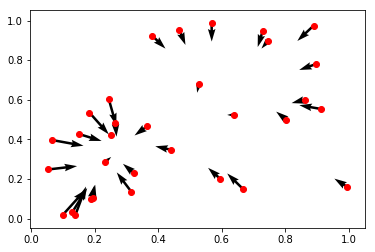

In [ ]:
plot_Nbody(xs,vs)

# Implementiamo All-Pairs N-Body con CUDA Python

L'dea generale dell'algoritmo *all-pairs* è che ogni particella venga assegnata ad un thread, che ne calcola l'accerelazione. Il thread $i$-esimo deve quindi calcolare la somma di tutte le interazioni $f_{ij}$ tra la particella $i$ e tutte le altre particelle $j$ con $1 \leq j \leq N$.
Il kernel così definito è 1D. I threads sono suddivisi in blocchi composti da $p$ threads. Per calcolare $f_{ij}$, il thread $i$ ha bisogno dei dati $m_j$, $x_j$, perciò **ogni dato viene letto esattamente $N$ volte**, una per thread.

Per diminuire le letture dalla global memory e ottimizzare il riutilizzo dei dati, utilizziamo la shared memory. Come abbiamo visto, la shared memory è condivisa tra i threads di uno stesso blocco. Assegnamo $p$ thread ad ogni blocco, cosi' da avere in totale $\lceil N/p \rceil$ blocchi.

Ogni blocco di threads ha risorse limitate in shared memory, percio' non possiamo caricare i dati relativi ai corpi (le masse `m` e le posizioni `x`) tutte in una volta. I dati dei corpi vengono quindi caricati in shared in gruppi di $p$ corpi alla volta. Dopodiche', e' necessario sincronizzare i threads per assicurarsi che tutti i dati siano stati caricati. Il thread $i$ calcola in maniera seriale le interazioni `f_ij` tra il corpo assegnatogli e i corpi caricati, e accumula i risultati in una somma parziale (la variabile `a_i` in memoria locale). Il processo viene poi ripetuto con i successivi $p$ corpi, e una volta terminati i corpi scrive il risultato nella memoria global.

![](http://media2mult.uos.de/pmwiki/fields/gpu09/m2m.d/N-Body-Simulation.SimulationWithCUDA/media/image/algorithm.png)

Questa tecnica prende il come di **tiling**, dall'inglese *tile* ("piastrella"), verra' approfondita nella prossima lezione.


In [ ]:
p = 32 #multiple of 32
threadsperblock = p

@cuda.jit('complex64(complex64, complex64, float32, complex64)',device = True)
def interaction(x_i, x_j, m, a):
    """iterazione f_ij tra le particelle i e j"""

    r_ij = x_j - x_i

    distSqrt = r_ij.real**2 + r_ij.imag**2

    f_ij = m*math.pow( distSqrt + EPS2, -1.5)

    a_new = a + r_ij * f_ij

    return a_new

@cuda.jit('void(complex64[:], float32[:], complex64[:])')
def acceleration_kernel(x, m, a):
    """Kernel che calcola le accelerazioni delle particelle"""
    i   = cuda.grid(1)
    s_i = cuda.threadIdx.x
    x_i = x[i]


    x_sh = cuda.shared.array(shape=(p), dtype = complex64)
    m_sh = cuda.shared.array(shape=(p), dtype = float32)

    iter = 0
    a_i  = complex64(0.0 +1j*0.0)
    N = x.shape[0]

    if (i < N):

        for k in range(0, N, p):
            idx = iter*p + s_i

            if (idx>=N): break
            #carico in shared p corpi
            x_sh[s_i] = x[idx]
            m_sh[s_i] = m[idx]

            cuda.syncthreads()

            #calcolo sequenziale delle iterazioni
            for j in range(0,p):
                a_i = interaction(x_i, x_sh[j], m_sh[j], a_i)
            #endfor
            cuda.syncthreads()
            iter = iter + 1
        #endfor
        a[i] = a_i
    #endif
    return

In [ ]:
@cuda.jit
def update_variables(a, x, v, dt, x_new, v_new):
    i = cuda.grid(1)

    if (i < a.shape[0]):
        v_new[i] = a[i]*dt     + v[i]
        x_new[i] = v_new[i]*dt + x[i]
    #endif
    return


def simulate_gpu(x0, v0, m, N, maxit, dt):
    blockspergrid = math.ceil(N/threadsperblock)

    d_x0 = numba.cuda.to_device(x0)
    d_v0 = numba.cuda.to_device(v0)
    d_m  = numba.cuda.to_device(m)
    d_x  = numba.cuda.device_array_like(x0)
    d_v  = numba.cuda.device_array_like(v0)
    d_a  = numba.cuda.device_array_like(x0)


    for s in range(maxit):
        #calcolo l'accelerazione
        acceleration_kernel[blockspergrid, threadsperblock](d_x0, d_m, d_a)
        #aggiorno le variabili
        update_variables[blockspergrid, threadsperblock](d_a, d_x0, d_v0, dt, d_x, d_v)
        d_x0.copy_to_device(d_x)
        d_v0.copy_to_device(d_v)
    #endfor

    return d_x.copy_to_host(), d_v.copy_to_host()

In [ ]:
x, v = simulate_gpu(x0, v0, m, N, 1, 1e-3)

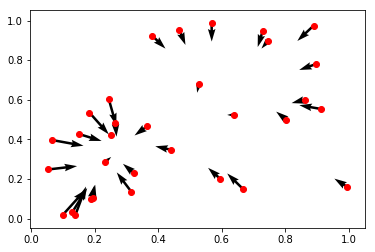

In [ ]:
plot_Nbody(x,v)

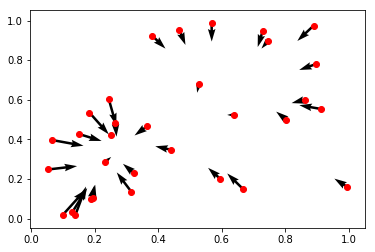

In [ ]:
plot_Nbody(xs,vs)

# Confronto

Per confrontare le due implementazioni, calcoliamo i tempi di esecutione per le simulazioni con $100$ passi temporali al variare del numero di particelle $N$.

In [ ]:
iters = 100

num_particles = [32, 64, 128, 256, 512, 1024]
cpu_time = np.zeros(len(num_particles))
gpu_time = np.zeros(len(num_particles))

for i, N in enumerate(num_particles):
    x0 = np.random.rand(N).astype(np.float32)+1j*np.random.rand(N).astype(np.float32)
    v0 = np.zeros((N,), dtype=np.complex64)
    m  = np.ones(N, dtype=np.float32)

    start = time.time()
    x, v = simulate_cpu(x0, v0, m, N, iters, 1e-3)
    end = time.time()
    cpu_time[i] = end-start

    #x0 = np.array(x0[:,0]+1j*x0[:,1], dtype = np.complex64)
    #v0 = np.zeros((N,), dtype=np.complex64)

    start = time.time()
    x, v = simulate_gpu(x0, v0, m, N, iters, 1e-3)
    end = time.time()
    gpu_time[i] = end-start

#end

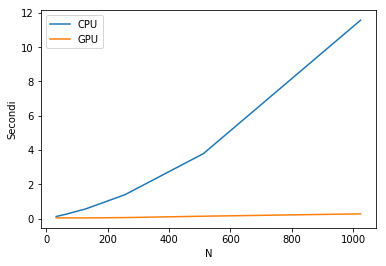

Speed-up: 40.77416362343854


In [ ]:
plt.figure()
plt.plot(num_particles, cpu_time)
plt.plot(num_particles, gpu_time)
plt.legend(['CPU', 'GPU'])
plt.xlabel('N')
plt.ylabel('Secondi')
plt.show()
print('Speed-up:', cpu_time[5]/gpu_time[5])

Per $1024$ particelle le simulazioni in CUDA Python sono molto più veloci rispetto al classico Python, nonostante stiamo calcolando anche i tempi di trasferimento in memoria tra host e device.

Calcoliamo ora i tempi di esecuzione delle simulazioni in CUDA Python al variare della taglia del blocchi `p`.

In [ ]:
bs = [16, 32, 64]
num_particles = [32, 64, 128, 256, 512, 1024]

gpu_time_bs = np.zeros((len(num_particles),len(bs)))

for i, N in enumerate(num_particles):
    x0 = np.random.rand(N).astype(np.float32)+1j*np.random.rand(N).astype(np.float32)
    v0 = np.zeros((N,), dtype=np.complex64)
    m  = np.ones(N, dtype=np.float32)
    for j, k in enumerate(bs):
        p = k #multiple of 32
        threadsperblock = p

        start = time.time()
        x, v = simulate_gpu(x0, v0, m, N, iters, 1e-3)
        end = time.time()
        gpu_time_bs[i,j] = end-start
    #end
#end

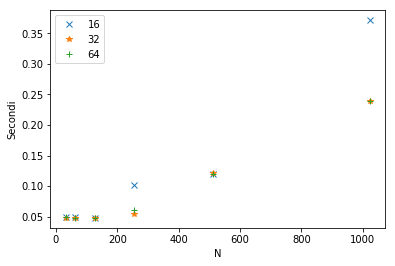

In [ ]:
plt.figure()
plt.plot(num_particles, gpu_time_bs[:,0], 'x')
plt.plot(num_particles, gpu_time_bs[:,1], '*')
plt.plot(num_particles, gpu_time_bs[:,2], '+')
plt.legend(['16', '32', '64'])
plt.xlabel('N')
plt.ylabel('Secondi')
plt.show()

Per $N \leq 512$ le performance sembrano equivalenti, mentre con $N=1024$ vediamo che scegliere `p` più piccolo della warpsize ($=32$) comporta un netto peggioramento delle performance!


NB: Quest'esempio è tratto dall'articolo *Fast N-Body Simulation with CUDA* di Nyland, Harris e Prins. Le immagini e l'analisi dei tempi di esecuzione sono tratte da  http://media2mult.uos.de/pmwiki/fields/gpu09/index.php?n=N-Body-Simulation.SimulationWithCUDA.
